# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251012-21-24-21 - 21-24-21


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(sdl, distance_array, )
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(sdl, hot_start_list)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 0, 0, 1, 0]
bin_hot_start_list_tensor = tensor([[1, 0, 0, 1, 0]])
The hot start distance is 21.00, compared to a best distance of 19.00.


Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    my_input, unrepeated_input = set_up_input_no_hot_start(sdl, device)

In [9]:
unrepeated_input.size()

torch.Size([1, 5])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 5])


Set up model with gradient required:

In [11]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

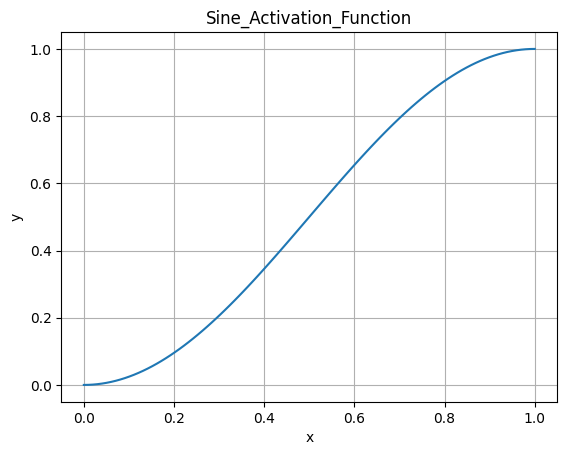

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 1.0734, -0.0542,  0.0028, -0.0077, -0.0165],
        [ 0.0415,  1.0499,  0.0312,  0.0012,  0.0065],
        [ 0.0605, -0.0492,  0.9770,  0.0342, -0.0678],
        [ 0.0229, -0.0070,  0.0317,  1.0404, -0.0533],
        [-0.0556,  0.0200, -0.0390,  0.1394,  1.0855]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.0330, -0.0207, -0.0237, -0.0532, -0.0308], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 1.0772, -0.0057, -0.0209, -0.0773,  0.0019],
        [-0.0480,  1.0936, -0.0928, -0.0366,  0.0401],
        [ 0.0120, -0.0478,  1.0144, -0.0390,  0.0456],
        [ 0.0028,  0.0290, -0.0603,  0.9865,  0.0277],
        [-0.0683, -0.0143, -0.0146, -0.0535,  1.0437]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([ 0.0704,  0.0604, -0.0469, -0.0700, -0.0453], device='cuda:0',
       requires_grad=True)}


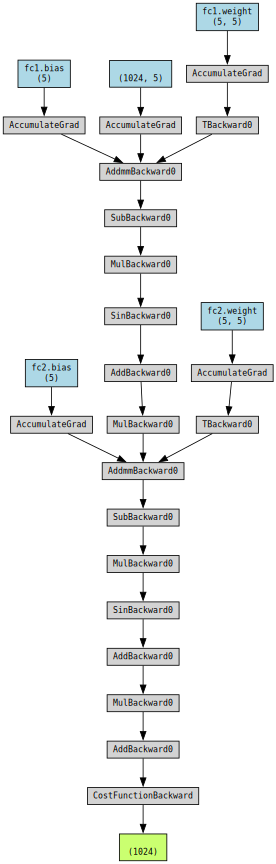

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 21.172 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 1473.50
Epoch 0, fc1.bias grad: 1041.92
Epoch 0, fc2.weight grad: 4714.86
Epoch 0, fc2.bias grad: 3374.13
Epoch 10, Average cost: 24.939 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 10, fc1.weight grad: 29007.32
Epoch 10, fc1.bias grad: 20511.29
Epoch 10, fc2.weight grad: 4130.88
Epoch 10, fc2.bias grad: 2511.90
Epoch 20, Average cost: 24.971 Epoch min cost:21.000, Lowest Cost to date: 19.000
Epoch 20, fc1.weight grad: 1146723.12
Epoch 20, fc1.bias grad: 810855.69
Epoch 20, fc2.weight grad: 13965.30
Epoch 20, fc2.bias grad: 8903.57
Epoch 30, Average cost: 23.096 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 30, fc1.weight grad: 1651027.62
Epoch 30, fc1.bias grad: 1167453.25
Epoch 30, fc2.weight grad: 6467.06
Epoch 30, fc2.bias grad: 6738.35
Epoch 40, Average cost: 23.602 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 40, fc1.weight grad: 511337.41


In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 19.000 at epoch 1.
The best known cost is 19.000
the hot start cost was 21.000.


Plot loss ratio by epoch:

Graph for Run ID: 20251012-21-24-21-21-24-21 being saved to graphs\20251012-21-24-21\21-24-21.png


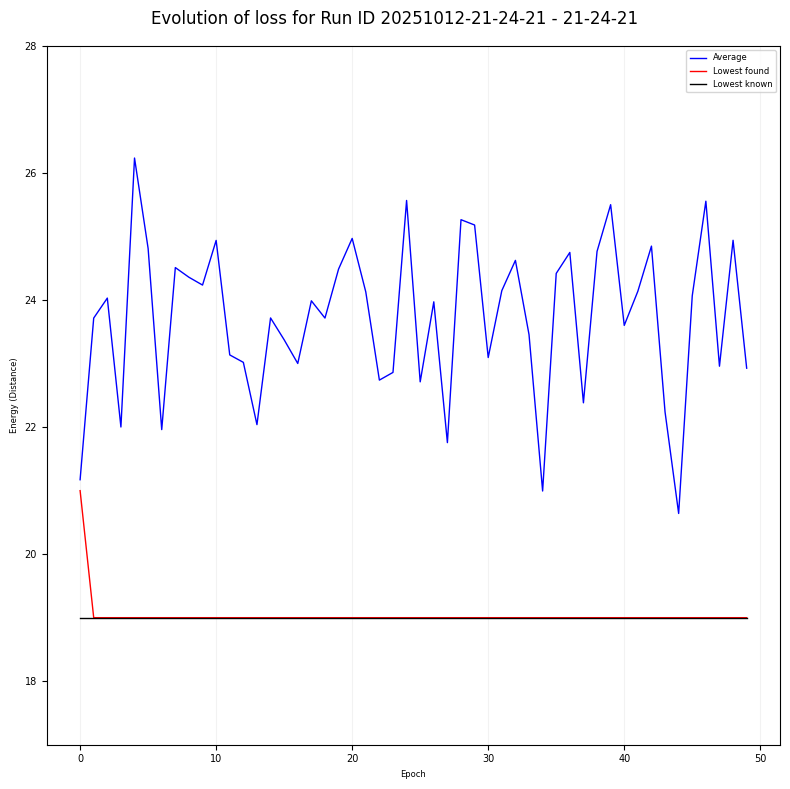

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 1.3810e+04, -5.4215e-02,  2.7676e-03,  1.3809e+04, -1.6462e-02],
        [ 7.5020e+03,  1.0497e+00,  3.1206e-02,  7.5020e+03,  6.4971e-03],
        [-3.1579e+03, -4.9172e-02,  9.7677e-01, -3.1579e+03, -6.7831e-02],
        [-3.3288e+04, -7.0273e-03,  3.1717e-02, -3.3287e+04, -5.3279e-02],
        [ 2.2237e+04,  1.9972e-02, -3.8945e-02,  2.2237e+04,  1.0852e+00]],
       device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([ 13809.2031,   7501.9385,  -3157.9714, -33288.5000,  22237.2656],
       device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[ 93.7987, 113.1980, 103.4635,  60.2943, 118.5941],
        [140.9444, 182.7214, 129.1974, 105.3436,  37.0012],
        [ 24.4179, -99.5047, -41.7696,   4.1738, -28.4026],
        [ 43.5358,  75.7801,  35.1257,  -9.6532, -21.8303],
        [ 67.7158,   7.9558,  24.3655,  77.1483, -12.3961]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
t